In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import pims
from pims import ImageSequence
from pims import pipeline
import trackpy as tp
import glob
import cv2 as cv

from skimage.transform import rescale, resize
from scipy.optimize import curve_fit

import tracking_tools as mylib

import time
import os

## this script version works with skimage v0.22.0

In [3]:
## Experiment values 
marble_diam = 3.5 # cm 
framerate = 1000.11 # Hz 

In [ ]:
## Import frames into PIMS imagesequence object
path = '/vid05_tiffs/*.tiff'
frames = ImageSequence(path)
print(frames)

output_dir = 'hog_output/vid05_yz_multi/'
fname_end = '_vid05_yz_multi'

In [5]:
## Make directory to store frames
if not os.path.exists(output_dir): # if not exits
    os.makedirs(output_dir) # make directory

## Make directory to store frames
if not os.path.exists(output_dir+'hog/'): # if not exits
    os.makedirs(output_dir+'hog/') # make directory

## Make directory to store frames
if not os.path.exists(output_dir+'hist_svg/'): # if not exits
    os.makedirs(output_dir+'hist_svg/') # make directory

## Make directory to store frames
if not os.path.exists(output_dir+'hist/'): # if not exits
    os.makedirs(output_dir+'hist/') # make directory

In [6]:
## Get values for image shape
nf,ny,nx,nc = np.shape(frames)

In [7]:
## Choose color maps/styles for some figures
cmappp = 'PuOr'
secondary_color ='magenta'

# Pxscale

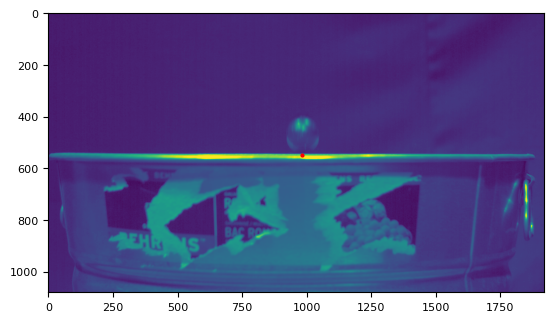

In [8]:
## Get center of impact coordinates
xc = 980; yc = 550
t0_frame = 117

fig,ax = plt.subplots(1,1,dpi=100) 
ax.scatter(xc,yc,c='r',s=4)
ax.imshow(frames[t0_frame][:,:,2]) 

pixel scaling: 38.57 px/cm


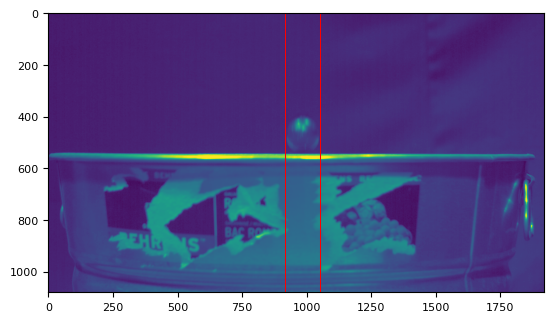

In [9]:
## Pxscale for above frames
y1 = 915
y2 = 1050
pxscale = mylib.get_pixel_scale(frames[t0_frame][:, :, 2], y1, y2, nx, marble_diam, 'v', 'cm')

# Image Processing
<a id='img_proc'></a>

### Extract color channels
<a id='ext_color_chan'></a>

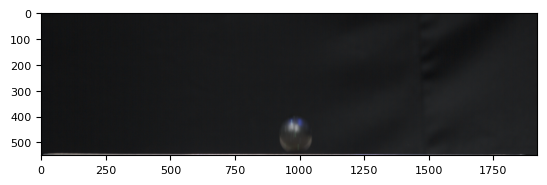

In [10]:
bcrop = 550 # amount to crop bottom of frames 
cframes = mylib.crop_frames(frames, bcrop=bcrop)
plt.imshow(cframes[t0_frame]) 

In [11]:
## Set extent of image in physical units (for imshow calls) 
img_extent = [-xc/pxscale, (nx-xc)/pxscale, (yc-bcrop)/pxscale, yc/pxscale] # w/ cropping
img_extent

[-25.40740740740741, 24.37037037037037, 0.0, 14.25925925925926]

In [ ]:
## Extract color channels
rframes = mylib.extract_single_color(cframes,0) # red channel
gframes = mylib.extract_single_color(cframes,1) # green channel
bframes = mylib.extract_single_color(cframes,2) # blue channel

gframes # dispay information

Text(0.5, 1.0, 'blue')

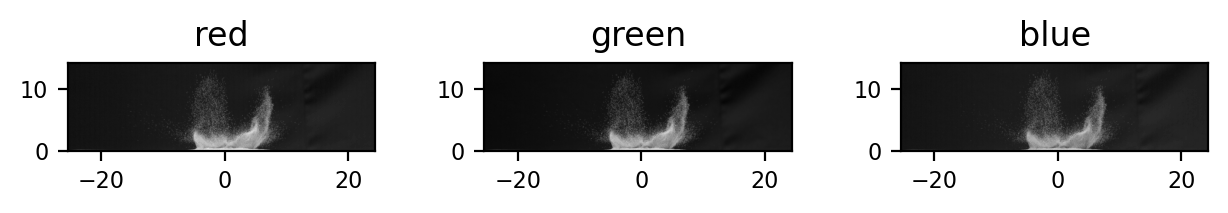

In [13]:
## Display the 3 color channels
ii = 170
fig,ax = plt.subplots(1,3,dpi=200)
fig.tight_layout(h_pad=1)
ax[0].imshow(rframes[ii],'gray', extent=img_extent)
ax[0].set_title('red')
ax[1].imshow(gframes[ii],'gray', extent=img_extent)
ax[1].set_title('green')
ax[2].imshow(bframes[ii],'gray', extent=img_extent)
ax[2].set_title('blue')
# plt.savefig('/Users/esteban/Desktop/aboveview.png',bbox_inches='tight',dpi=200)

### Median image subtraction
<a id='med_img_sub'></a>

In [14]:
# Make a median image
diff = 100 # distance between images used for median
end_med = 200 # last frame to be used as median

bmedianim = mylib.make_median(bframes[:end_med],0,diff) 
rmedianim = mylib.make_median(rframes[:end_med],0,diff) 
gmedianim = mylib.make_median(gframes[:end_med],0,diff) 

# Substract median image from all frames
bproc = mylib.subtract_median(bframes, bmedianim)
rproc = mylib.subtract_median(rframes, rmedianim)
gproc = mylib.subtract_median(gframes, gmedianim)


Text(0.5, 1.0, 'green proc')

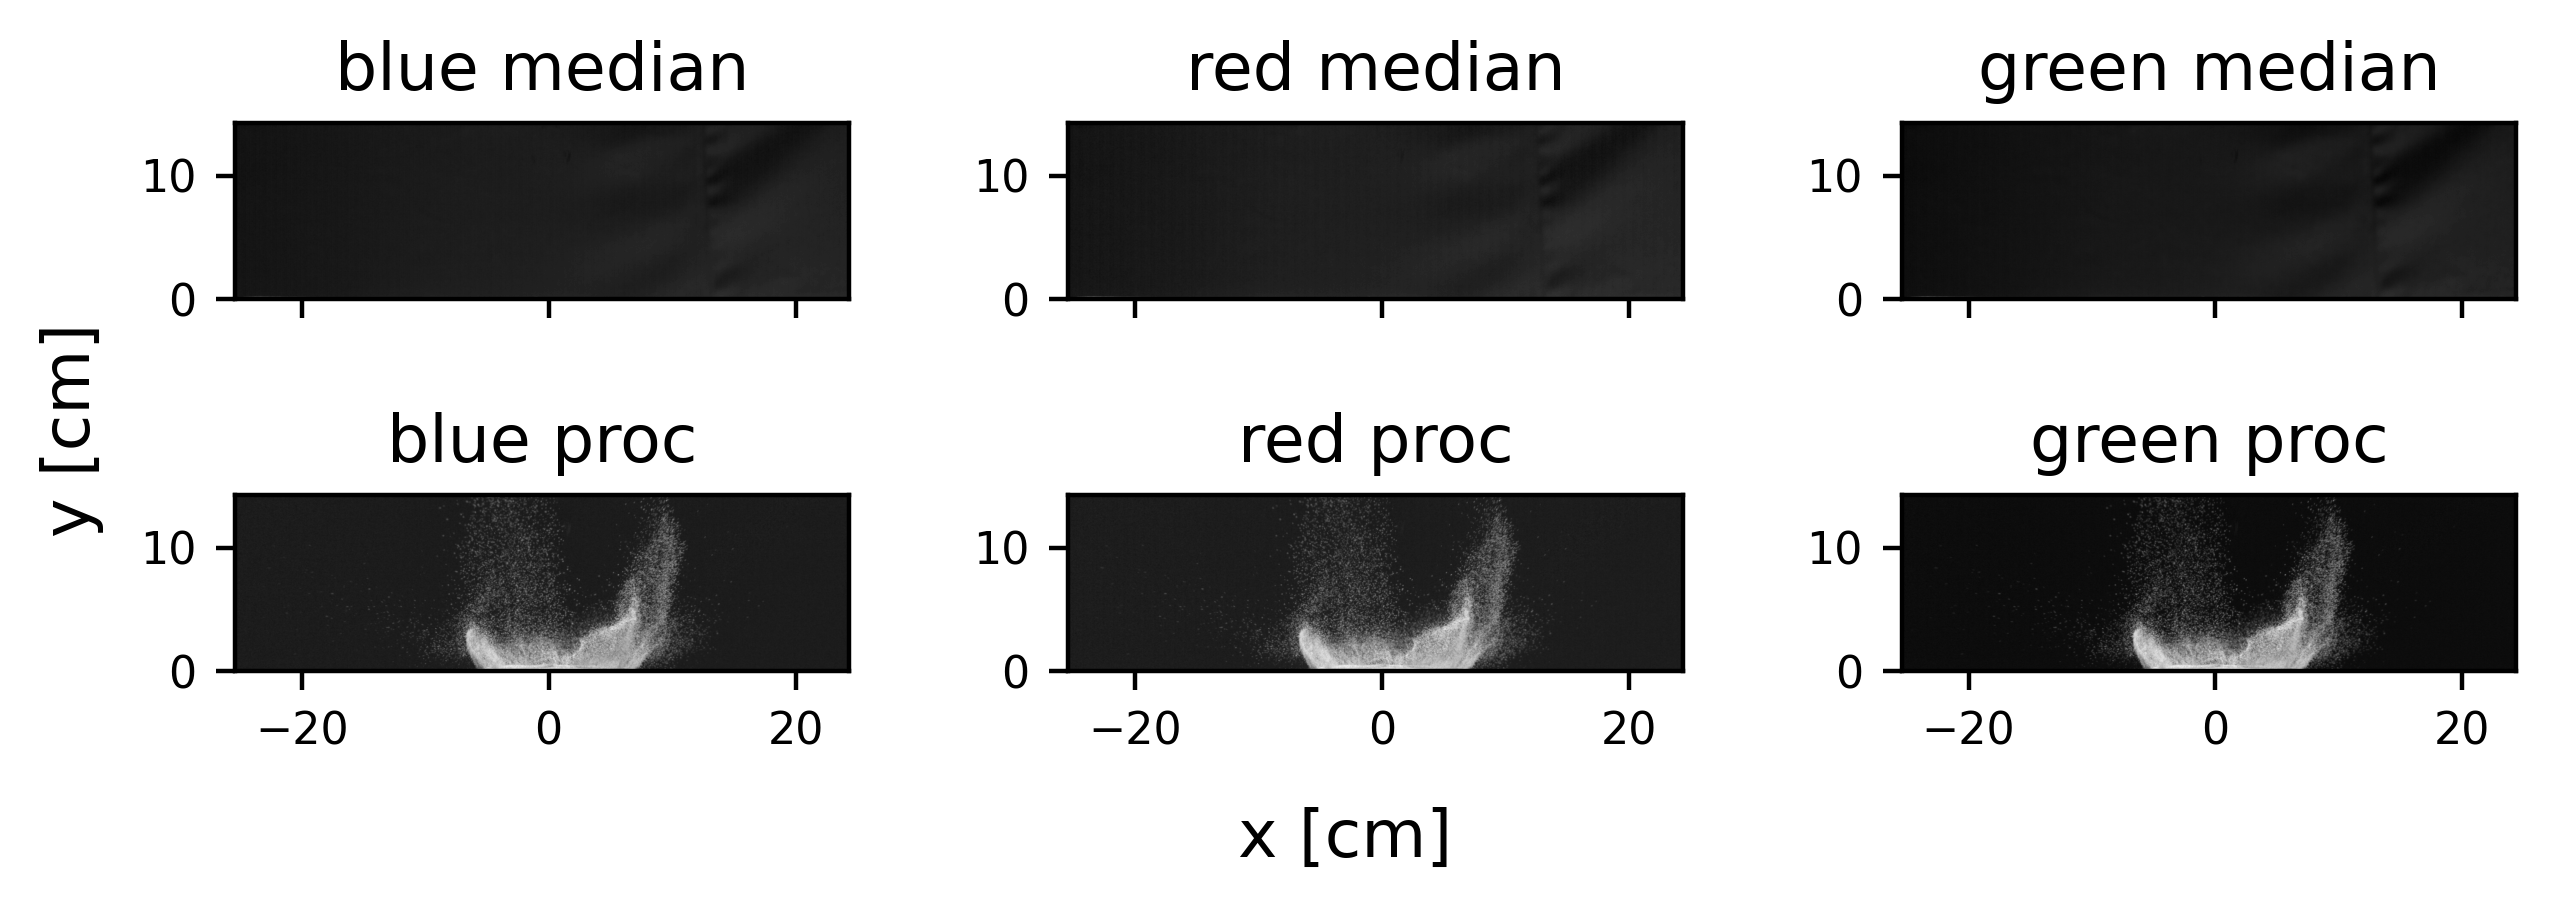

In [15]:
## Plot 3 color channels median subtract results
idx = 200
fig,ax = plt.subplots(2,3,dpi=400, sharex=True) 
fig.tight_layout(h_pad=-18)
fig.supxlabel('x [cm]', y=0.27)
fig.supylabel('y [cm]', x=-0.01)

ax[0,0].imshow(bmedianim,'gray', extent=img_extent)
ax[0,0].set_title('blue median') 
ax[1,0].imshow(bproc[idx],'gray', extent=img_extent)
ax[1,0].set_title('blue proc') 
ax[0,1].imshow(rmedianim,'gray', extent=img_extent)
ax[0,1].set_title('red median') 
ax[1,1].imshow(rproc[idx],'gray', extent=img_extent)
ax[1,1].set_title('red proc') 
ax[0,2].imshow(gmedianim,'gray', extent=img_extent)
ax[0,2].set_title('green median') 
ax[1,2].imshow(gproc[idx],'gray', extent=img_extent)
ax[1,2].set_title('green proc') 

# HoG
### modified from code written by Alice C. Quillen

In [16]:
from skimage.feature import hog
from skimage import data, exposure

# compute histogram of oriented gradients (hog) of grey image 
# return feature vector of hog and hog_image for display
# di and dj are cell sizes called to make hog
# norientations = number of orientations for histograms
# extent is for real sizes in display
# if showit=1 make imshow it 
# see https://www.learnopencv.com/histogram-of-oriented-gradients/
def compute_hog(image,extent,di,dj,norientations,showit):

    fdo, hog_image = hog(image, orientations=norientations, pixels_per_cell=(di, dj),
                    cells_per_block=(1, 1), visualize=True, feature_vector = False)
    print(fdo.shape)  # format of feature vector thing
    
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1))
    if (showit==1):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0, wspace=0)
        ax1.imshow(image, cmap=plt.cm.gray, extent=extent)
        ax1.set_title('Input image')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray, extent=extent)  
        ax2.set_title('Histogram of Oriented Gradients')
        #plt.show()
    return fdo, hog_image_rescaled, hog_image

In [17]:
# compute arrows for each cell of hog
# fdo is output of hog, feature vector histograms
# di and dj are cell sizes called to make hog
# xvec and yvec are positions of pixels in real space
# return x,y positions and orientations of arrows
# arrows are computed from the mean of the hog histograms
# also returns an image with angle values in it

# colorbar and quiver arrows now agree 
# note that HOG is for finding the orientation of the gradient, we rotate the HOG vectors by 90 degrees to measure slope of ejecta curtain 
def mkarrows(fdo, hog_image_rescaled, di, dj, xvec, yvec, image):
    
    lhist = fdo.shape[4]  # length of histogram
    xarr = np.array([])
    yarr = np.array([])
    #garr = np.array([])
    ang_arr = np.array([])
    ni = fdo.shape[1] # fdo[n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient]
    nj = fdo.shape[0]
    dphi = np.pi/lhist  # angular bin width in radians
    phiarr = np.arange(0, lhist)*dphi + dphi/2 # angles for each bin, centered, not sure about extra dphi/2
    # phi only goes from 0, to pi
    hx = np.cos(phiarr*2)  # 2 is because of pi redundancy
    hy = np.sin(phiarr*2)
    ang_img = np.zeros((nj,ni))
    for i in range(ni):
        x0=xvec[i*di + int(di/2)]  
        for j in range(nj):
            y0 = yvec[-1] - yvec[j*dj + int(dj/2)]  # flip y? yes
            # print(yvec[-1]-yvec[j*dj + int(dj/2)])
            xarr = np.append(xarr,x0)
            yarr = np.append(yarr,y0)
            # hist = np.squeeze(fdo[i,j,0,0,:])
            hist = fdo[j,i,0,0,:]
            sum_hx = np.sum(hist*hx)  # compute xbar from histogram (means)
            sum_hy = np.sum(hist*hy)  # compute ybar
            ang = np.arctan2(sum_hy, sum_hx)/2 
            ang_arr = np.append(ang_arr, ang)  # list of angles
            ang_img[j,i] = ang #  an image where value in each position is angle
    

    #ang_arr_off = np.pi/2 - ang_arr # mid bin , flip y with minus sign in angle?
    ang_img = np.pi/2 - ang_img # nescessary for the angle of the arrow to match colorbar values 
    ang_img_corr = ang_img*180/np.pi
    ii = (ang_img_corr > 90)
    ang_img_corr[ii] -= 180  # should now go from -90 to 90
    uarr = np.sin(ang_arr) # in [-1,1]
    varr = np.cos(ang_arr)  
    
    return xarr, yarr, uarr, varr, ang_arr, ang_img, ang_img_corr

In [18]:
def sum_frames(frames,ff,nframes,nskip):
    '''
    Parameters:
    -----------
    frames : pims ImageSequence
        Video frames to sum. Must have shape (N,ny,nx) where N is some number of video frames
    ff : int
        Frame number to begin summation
    nframes : int
        Number of total frames to use in summation
    nskip : int
        Number of frames to skip between frames used in summation (i.e. sum every nskip frames) 

    Returns:
    --------
    sum_frames : 
    '''
    nf,ny,nx = np.shape(frames)
    summed_img=np.zeros([ny,nx])
    fac = 1/nframes
    for ii in range(nframes):
        summed_img += fac*frames[ff+ii*nskip]

    return summed_img
    

In [19]:
## Choose which frames to use in HOG analysis

# chosen_img = bframes # not median subtracted
chosen_img = bproc # median subtracted 

Text(0, 0.5, 'y [cm]')

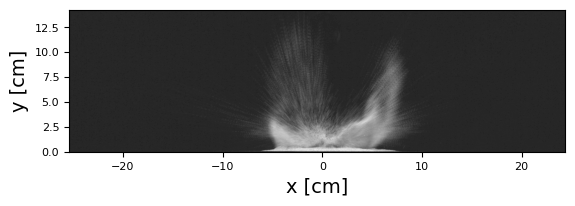

In [20]:
## Make streaked images by summing consecutive frames (helps with noise in HOG analysis) 
nframes = 6 # num of total frames to use in summation
kk = 2 # num frames to skip between summed frames 
dt = 50 # num frames after t0 

blue = sum_frames(chosen_img, t0_frame+dt, nframes, kk) # summed frames analysis is performed on 
blue_orig = sum_frames(bframes, t0_frame+dt, nframes, kk) # summed frames for display/plotting 

plt.imshow(blue, 'gray', extent=img_extent) 
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

(13, 48, 1, 1, 24)


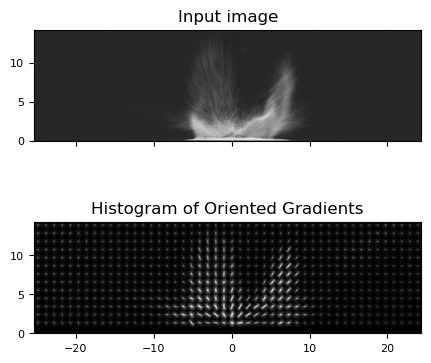

In [21]:
## Test parameters for HOG analysis 
di=40
dj=40
norientations = 24
showit=1

xvec = np.linspace(-xc/pxscale, (nx-xc)/pxscale, nx) 
yvec = np.linspace((yc-ny)/pxscale, yc/pxscale, ny) 

fdo, hog_image_rescaled, hog_image_1 = compute_hog(blue, img_extent, di, dj, norientations, showit) # do HOG 
xarr, yarr, uarr, varr, ang_arr, ang_img, ang_img_corr = mkarrows(fdo, hog_image_rescaled, di, dj, xvec, yvec, blue) # make arrows for quiver plot 


ff=167, kk=2, di=40, dj=40, norientations=24


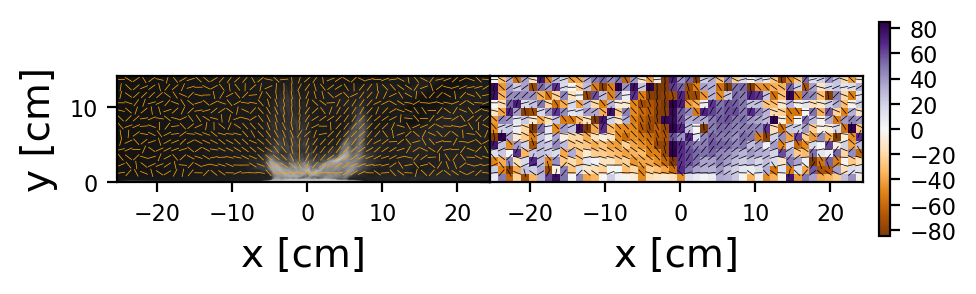

In [22]:
## Plot HOG results 

print('ff=%i, kk=%i, di=%i, dj=%i, norientations=%i' %(t0_frame+dt,kk,di,dj,norientations))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(5, 1.9), sharex=True, sharey=True, facecolor='white', dpi=200)  
plt.subplots_adjust(bottom=0.16, top=0.99, left=0.14, right=0.96, hspace=0, wspace=0)
# ax1.imshow(blue, cmap=plt.cm.gray,extent=img_extent)
ax1.imshow(blue_orig, cmap=plt.cm.gray, extent=img_extent)
ax1.quiver(xarr, yarr-(ny-yc)/pxscale, uarr, varr, color='orange', pivot='mid', width=0.002,\
              headwidth=0, headlength=0, headaxislength=0)

ax1.set_xlabel('x [cm]'); ax2.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')

cmapp = mpl.colormaps[cmappp]
# cmapp.set_under(color='k')
# cmapp.set_over(color='k')
im=ax2.imshow(ang_img_corr, extent=img_extent, cmap=cmapp, vmin=-85, vmax=85)

ax2.quiver(xarr, yarr-(ny-yc)/pxscale, uarr, varr, color='k', pivot='mid', width=0.002,\
              headwidth=0, headlength=0, headaxislength=0)
plt.colorbar(im, ax=(ax1,ax2), fraction=0.07, pad=0.02, shrink=0.68, anchor=(0.00, 0.5),\
                ticks=[-80,-60,-40,-20,0,20,40,60,80])


#ax1.text(-85,-20,froot[1:3]+r'$^\circ$',color='black',fontsize=16)
#plt.savefig(froot+'quiver.png',dpi=200)

Text(0.5, 1.0, 'hog_img coarse')

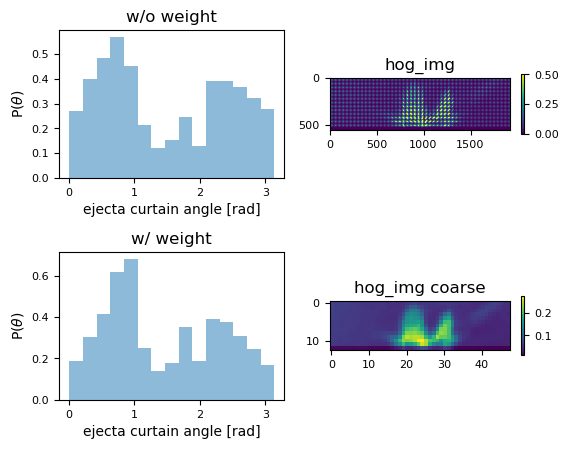

In [23]:
## Checking histogram of ejecta angles and HOG result
# histograms w/ and w/o weighting data points by (downsampled) HOG result 

ni = fdo.shape[1] # fdo[n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient]
nj = fdo.shape[0]

fs=10
fig,axs = plt.subplots(2,2)
plt.subplots_adjust(hspace=0.5)
ax = axs.flatten()
ax[0].hist(ang_img.flatten(), bins=15, density=True, alpha=0.5) # hist w/o weighting
ax[0].set_title('w/o weight')
ax[0].set_ylabel(r'P($\theta$)', fontsize=fs)
ax[0].set_xlabel('ejecta curtain angle [rad]', fontsize=fs) 

# re = rescale(hog_image_1, (1./di, 1./dj)) # downscale hog result; from skimage.transform
re2 = resize(hog_image_1, (nj, ni)) # downscale hog result; from skimage.transform
ax[2].hist(ang_img.flatten(), weights=re2.flatten(), bins=15, density=True, alpha=0.5) # hist w/ weighting 
ax[2].set_title('w/ weight')
ax[2].set_ylabel(r'P($\theta$)', fontsize=fs)
ax[2].set_xlabel('ejecta curtain angle [rad]', fontsize=fs) 

sh = 0.4
im = ax[1].imshow(hog_image_1, vmin=0, vmax=0.5)
plt.colorbar(im, shrink = sh)
ax[1].set_title('hog_img')

im1 = ax[3].imshow(re2)
plt.colorbar(im1, shrink=sh)
ax[3].set_title('hog_img coarse')


In [24]:
## Perform HoG on multiple series of frames

## Initialize parameters
ff = t0_frame # starting frame 

## Save tracking parameters to text file
f = open(output_dir+'HoG_parameters.txt', 'w')
f.write(f'ff=%i\nkk=%i\ndi=%i\ndj=%i\nnorientations=%i' \
      %(ff,kk,di,dj,norientations))
f.close()

nxx, nyy = np.shape(chosen_img[0])
niterations = (nf-t0_frame)//(nframes*kk) # number of loop iterations 
ang_corr = np.zeros([niterations, nxx//di, nyy//dj])
hog_img = np.zeros([niterations, nxx, nyy])
hog_img_rescale = np.zeros([niterations, nxx, nyy])

## Begin loop for HoG on entire original video
for ii in range(niterations):
    print('current frame: %i' %ff) # current start frame
    print('current time: %.6f sec' %((ff-t0_frame)/framerate))
    if (ff+nframes*kk) <= len(chosen_img): # check for overshooting index of last used frame

        # prepare streaked image by summing 6 consecutive frames spaced by kk
        blue = sum_frames(chosen_img, ff, nframes, kk)
        blue_orig = sum_frames(bframes, ff, nframes, kk)
        
        # prepare settings for hog finding routine
        showit=0
        # compute hog with current streaked image
        fdo, hog_image_rescaled, hog_image_1 = compute_hog(blue, img_extent, di, dj, norientations, showit)
        
        # prepare arrows for quiver plot
        xvec = np.linspace(-xc/pxscale, (nx-xc)/pxscale, nx) 
        yvec = np.linspace((yc-ny)/pxscale, yc/pxscale, ny) 
        xarr,yarr,uarr,varr,ang_arr,ang_img,ang_img_corr = mkarrows(fdo, hog_image_rescaled, di, dj, xvec, yvec, blue)

        ang_corr[ii,:,:] = ang_img_corr
        hog_img[ii,:,:] = hog_image_1
        hog_img_rescale[ii,:,:] = hog_image_rescaled
        
        # plot hog and quiver plot...
        print('ff=%i, kk=%i, di=%i, dj=%i, norientations=%i' %(ff,kk,di,dj,norientations))
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(5, 1.9), sharex=True, sharey=True, facecolor='white', dpi=200)  
        plt.subplots_adjust(bottom=0.16, top=0.99, left=0.14, right=0.96, hspace=0, wspace=0)
        # ax1.imshow(blue, cmap=plt.cm.gray,extent=img_extent)
        ax1.imshow(blue_orig, cmap=plt.cm.gray,extent=img_extent)
        ax1.quiver(xarr,yarr-(ny-yc)/pxscale,uarr,varr,color='orange',pivot='mid',width=0.002,\
                      headwidth=0,headlength=0,headaxislength=0)

        ax1.set_ylabel('y [cm]', fontsize=8)
        fig.text(0.48, 0.27, 'x [cm]', va='center', rotation='horizontal', fontsize=8)

        ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
        ax1.xaxis.set_tick_params(labelsize=6) # right figure column
        ax1.yaxis.set_tick_params(labelsize=6)
        ax2.xaxis.set_tick_params(labelsize=6) # right figure column
        ax2.yaxis.set_tick_params(length=0, width=0, pad=0, labelsize=0)
        
        
        # ax1.quiver(xarr,yarr,uarr,varr,color='orange',pivot='mid',width=0.002,\
        #               headwidth=0,headlength=0,headaxislength=0)
        # cmap = mpl.colormaps[cmappp] # alternative coloring
        # cmap.set_under(color='black')
        # cmap.set_over(color='black')
        # plt.imshow(ang_img_corr, extent=img_extent, cmap=cmap, vmin=-70, vmax=70)

        im = ax2.imshow(ang_img_corr, extent=img_extent, cmap=cmappp, vmin=-90, vmax=90)
        ax2.quiver(xarr, yarr-(ny-yc)/pxscale, uarr, varr, color=secondary_color, pivot='mid', width=0.002,\
                      headwidth=0, headlength=0, headaxislength=0)
        cb = plt.colorbar(im,ax=(ax1,ax2), fraction=0.07, pad=0.02, shrink=0.50, anchor=(0.00, 0.5),\
                        ticks=[-80,-40,0,40,80])
        cb.ax.tick_params(labelsize=6)

        ax1.text(-20,16.,'time = %.2f ms' %((ff-t0_frame)/framerate*1000), color='k',fontsize=8,zorder=20)
        plt.savefig(output_dir+'hog/frame_'+str(ff).zfill(2)+'.png', dpi=400, bbox_inches='tight')
        
        # for memeory control
        plt.cla() # Clear the current axes
        plt.clf() # Clear the current figure
        plt.close('all') # Closes all the figure windows
        plt.close(fig)
        
        # prepare for next interation of loop 
        ff = (ff+nframes*kk) # update start frame to begin next iteration of loop
        print('last frame: %i' %(ff)) # print last frame
        print('-------------------------')
    
    else:
        print('broke loop on frame: %i' %ff)
        break


current frame: 117
current time: 0.000000 sec
(13, 48, 1, 1, 24)
ff=117, kk=2, di=40, dj=40, norientations=24
last frame: 129
-------------------------
current frame: 129
current time: 0.011999 sec
(13, 48, 1, 1, 24)
ff=129, kk=2, di=40, dj=40, norientations=24
last frame: 141
-------------------------
current frame: 141
current time: 0.023997 sec
(13, 48, 1, 1, 24)
ff=141, kk=2, di=40, dj=40, norientations=24
last frame: 153
-------------------------
current frame: 153
current time: 0.035996 sec
(13, 48, 1, 1, 24)
ff=153, kk=2, di=40, dj=40, norientations=24
last frame: 165
-------------------------
current frame: 165
current time: 0.047995 sec
(13, 48, 1, 1, 24)
ff=165, kk=2, di=40, dj=40, norientations=24
last frame: 177
-------------------------
current frame: 177
current time: 0.059993 sec
(13, 48, 1, 1, 24)
ff=177, kk=2, di=40, dj=40, norientations=24
last frame: 189
-------------------------
current frame: 189
current time: 0.071992 sec
(13, 48, 1, 1, 24)
ff=189, kk=2, di=40, dj

### to make video w/ ffmpeg, use command:
##### ffmpeg -framerate 4 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p output.mp4

(13, 48, 1, 1, 24)
ff=117, kk=2, di=40, dj=40, norientations=24
(13, 48, 1, 1, 24)
ff=165, kk=2, di=40, dj=40, norientations=24
(13, 48, 1, 1, 24)
ff=213, kk=2, di=40, dj=40, norientations=24
(13, 48, 1, 1, 24)
ff=261, kk=2, di=40, dj=40, norientations=24
(13, 48, 1, 1, 24)
ff=309, kk=2, di=40, dj=40, norientations=24


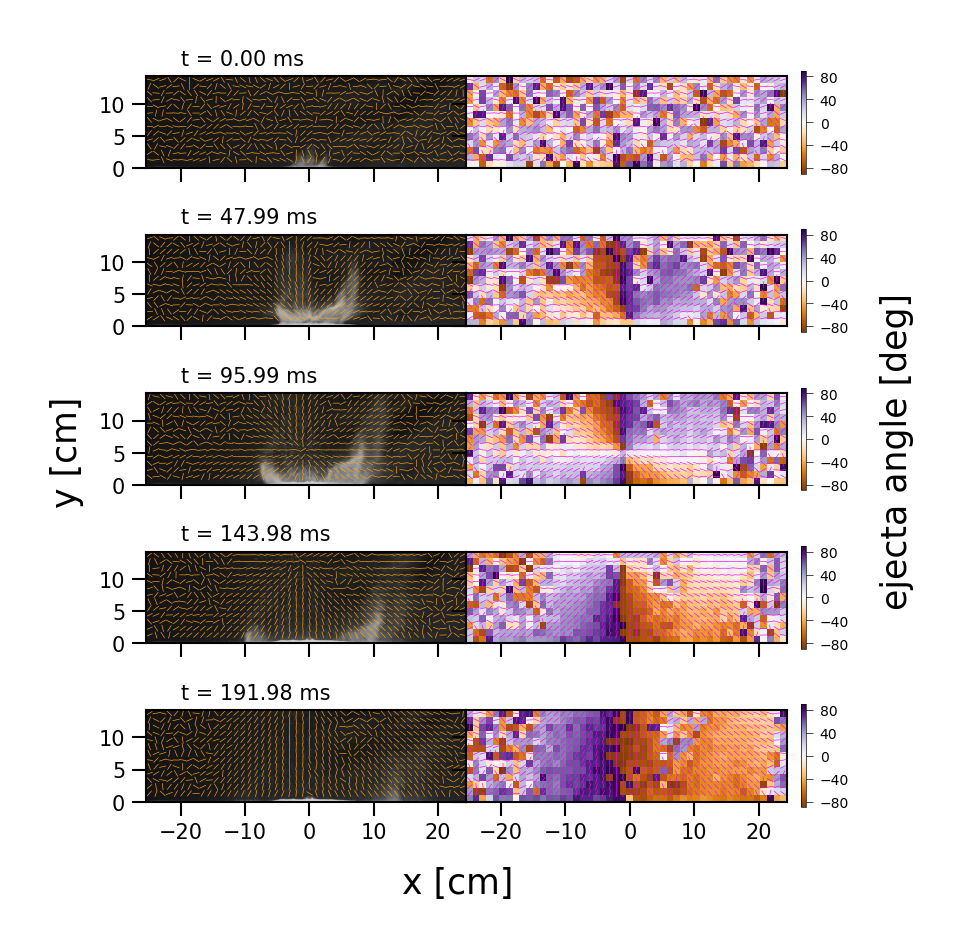

In [25]:
## Plot postcards of HOG results 
N = 5
nn = 24 # some multiple of nframes*kk to make time sync up
ff = t0_frame 

## Plot final velocities overlaying original frame 
fig, ax = plt.subplots(N, 2, dpi=500, sharex=True, sharey=True,facecolor='white') 
fig.subplots_adjust(bottom=0.06, top=0.39, left=0.14, right=0.36, hspace=0, wspace=0)

for ii, jj in enumerate(np.linspace(0, len(chosen_img), nn)):
    # print(ii, int(jj), ff)
    jj=int(jj) 
    
    if jj>len(chosen_img):
        break
    if ii == N:
        break
    
    ## Sum frames to be displayed in background
    blue = sum_frames(chosen_img, ff, nframes, kk)
    blue_orig = sum_frames(bframes, ff, nframes, kk)
    
    # compute hog with current streaked image
    showit=0
    fdo,hog_image_rescaled, hog_image_1 = compute_hog(blue, img_extent, di, dj, norientations, showit)
    
    # prepare arrows for quiver plot
    xvec = np.linspace(-xc/pxscale, (nx-xc)/pxscale, nx) 
    yvec = np.linspace((yc-ny)/pxscale, yc/pxscale, ny) 
    xarr,yarr,uarr,varr,ang_arr,ang_img,ang_img_corr = mkarrows(fdo, hog_image_rescaled, di, dj, xvec, yvec, blue)

    # plot hog and quiver plot...
    print('ff=%i, kk=%i, di=%i, dj=%i, norientations=%i' %(ff,kk,di,dj,norientations))
    # ax[ii,0].imshow(blue, cmap=plt.cm.gray,extent=img_extent)
    ax[ii,0].imshow(blue_orig, cmap=plt.cm.gray,extent=img_extent)
    ax[ii,0].quiver(xarr,yarr-(ny-yc)/pxscale,uarr,varr,color='orange',pivot='mid',width=0.002,\
                  headwidth=0,headlength=0,headaxislength=0)
    
    im = ax[ii,1].imshow(ang_img_corr,extent=img_extent,cmap=cmappp,vmin=-90, vmax=90)
    ax[ii,1].quiver(xarr,yarr-(ny-yc)/pxscale,uarr,varr,color=secondary_color,pivot='mid',width=0.002,\
                  headwidth=0,headlength=0,headaxislength=0)
    cb = plt.colorbar(im, ax = (ax[ii,0],ax[ii,1]), fraction=0.07, pad=0.02, shrink=0.65, anchor=(0.00, 0.5),\
                    # ticks=[-80,-60,-40,-20,0,20,40,60,80])
                     ticks=[-80,-40,0,40,80])
    cb.ax.tick_params(length=1.0, width=0.1, labelsize=2, pad=1.)
    cb.outline.set_linewidth(0.1)

    for location in ['left', 'right', 'top', 'bottom']:
        ax[ii,0].spines[location].set_linewidth(0.3)
        ax[ii,1].spines[location].set_linewidth(0.3)


    # ax[ii,0].text(-18.0, 20.0, 't = %.2f ms' %((jj)/framerate*1000), fontsize=3)
    ax[ii,0].text(-20.0, 16.0, 't = %.2f ms' %((ff-t0_frame)/framerate*1000), fontsize=3)
    ax[ii,0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax[ii,0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    ax[ii,0].xaxis.set_tick_params(length=2.0, width=0.3, pad=1., labelsize=3) # left figure column
    ax[ii,0].yaxis.set_tick_params(length=2.0, width=0.3, pad=1., labelsize=3) 
    ax[ii,1].xaxis.set_tick_params(length=2.0, width=0.3, pad=1., labelsize=3) # right figure column
    ax[ii,1].yaxis.set_tick_params(length=2.0, width=0.3, pad=1., labelsize=3)

    # prepare for next interation of loop 
    ff = (ff+nn*kk) # update start frame to begin next iteration of loop

## Plot axes labels 
fig.text(0.22, 0.04, 'x [cm]', va='center', rotation='horizontal', fontsize=5)
fig.text(0.11, 0.22, 'y [cm]', va='center', rotation='vertical', fontsize=5)
fig.text(0.38, 0.22, 'ejecta angle [deg]', ha='right', va='center', rotation='vertical', fontsize=5)


plt.savefig(output_dir+'hog_postcards.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'hog_postcards.svg')#, dpi=500, bbox_inches='tight') 

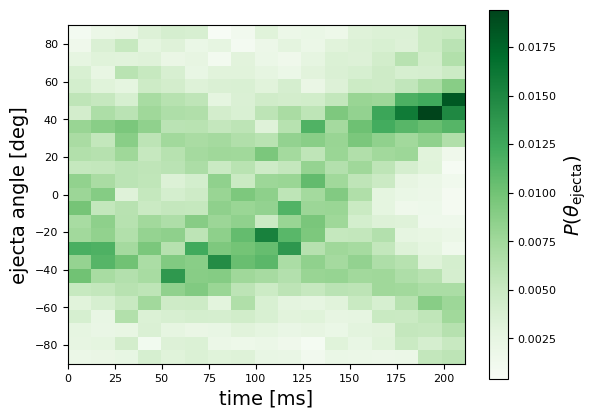

In [26]:
## Ejecta angle probability distribtion as function of time

nbins = 25
ttt = np.linspace(0, nf-t0_frame, len(ang_corr))/framerate*1000 ; # time array in ms
xunits = 'ms' # xaxis label 
cunits = xunits # colorbar label 

jj=17 # time index to stop analysis/plotting (from t=0) 
dummy_times_axis = np.linspace(0, ttt[jj], jj)
hst_img = np.zeros([nbins, len(ang_corr[:jj])]) 


for bb in range(len(ang_corr[:jj])): 
    
    # re = rescale(hog_img[bb], (1/di, 1/dj)) # downsample hog result 
    re = resize(hog_image_1, (nj, ni)) # downscale hog result; from skimage.transform
    yy, xx = np.histogram(ang_corr[bb].flatten(), weights=re.flatten(), \
                              range=(-90, 90), bins=nbins, density=True) # equal bin range; weighted data 

    hst_img[:,bb] = yy # append probabiltiy distribution 


## Plot it! 
fig, ax = plt.subplots(1,1)
im_ = ax.imshow(hst_img, extent=[np.min(dummy_times_axis), np.max(dummy_times_axis), -90, 90], cmap="Greens")

ax.set_ylabel('ejecta angle [deg]')
ax.set_xlabel('time [%s]' %xunits)
ax.set_aspect('equal')
plt.colorbar(im_, label=r'$P(\theta_{\rm ejecta})$')
# plt.legend()
plt.ylim(-90,90)
# ax.set_xlim()

plt.savefig(output_dir+'pdfs_3D_nofit.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'pdfs_3D_nofit.svg')#, dpi=500, bbox_inches='tight') 

0
1
2
3


/Users/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3000.

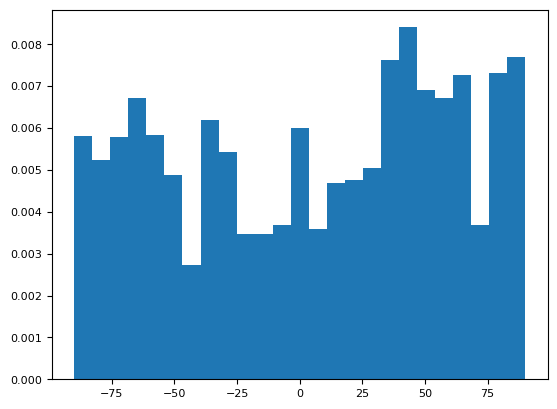

In [27]:
## Fit measured distributions to guassian mixuture model 

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


params_lst = np.zeros([len(ang_corr),3])
cov_lst = np.zeros([len(ang_corr),3,3])

for bb in range(len(ang_corr)): 
    print(bb)
    fig, ax = plt.subplots(1,1, dpi=100) 
    # re = rescale(hog_img[bb], (1/di, 1/dj)) # downsample hog result 
    re = resize(hog_img[bb], (nj, ni)) # downscale hog result; from skimage.transform
    yy, xx, patches = ax.hist(ang_corr[bb].flatten(), weights=re.flatten(), \
                              range=(-90, 90), bins=nbins, density=True) # equal bin range; weighted data 

    xx = (xx[1:]+xx[:-1])/2 # for len(x)==len(y)

    # expected = (-45., 10., 0.01, 45., 10., 0.01)
    params, cov = curve_fit(gauss, xx, yy, maxfev=3000)#,expected)
    # print(params)
    sigma = np.sqrt(np.diag(cov))
    
    ax.plot(xx, gauss(xx,*params), color='k', label=r'P($\theta$) model')
    
    col = (xx-xx.min())/(xx.max()-xx.min())
    cm = mpl.colormaps[cmappp]
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    
    ax.text(102.0,.004,'$\mu$1= %.1f\n$\sigma$1= %.1f\nA1= %.1e' \
             %(params[0], params[1], params[2]))#,params[3], params[4], params[5]))
    
    ax.set_ylabel(r'P($\theta$)')
    ax.set_xlabel('ejecta curtain angle [deg]') 
    
    plt.legend()
    plt.savefig(output_dir+'hist/hist'+str(bb).zfill(2)+'.png', dpi=400, bbox_inches='tight')
    plt.savefig(output_dir+'hist_svg/hist'+str(bb).zfill(2)+'.svg')
    plt.close()

    params_lst[bb] = params
    cov_lst[bb] = cov



In [ ]:
## Extract fit parameters and errors to their own arrays 
mu1 = params_lst[:,0] # mean 1
sig1 = params_lst[:,1] # std 1
# mu2 = params_lst[:,3] # mean 2
# sig2 = params_lst[:,4] # std 2

cov_diag = np.array([np.diagonal(cov_lst[ii]) for ii in range(len(cov_lst))]) # errors of main parameters (i.e. diagonal of cov matrix from fits)
mu1_err = np.sqrt(cov_diag[:,0]) # mean 1 error
sig1_err = np.sqrt(cov_diag[:,1]) # std 1 error
# mu2_err = np.sqrt(cov_diag[:,3]) # mean 2 error
# sig2_err = np.sqrt(cov_diag[:,4]) # std 2 error


In [ ]:
## Probabily distributions for ejecta angles in time 
fig,ax = plt.subplots(1,1)
ax.set_ylabel(r'P($\theta_{\rm ejecta}$) model')
ax.set_xlabel('ejecta curtain angle [deg]') 

# cmap = mpl.cm.viridis
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=np.min(ttt), vmax=np.max(ttt[jj]))

for ii, pp in enumerate(params_lst[:jj]):
    color = cmap(norm(ttt[ii]))
    ln = ax.plot(xx, gauss(xx, *pp), c=color)#, label='tt=%i' %ii )#,label=r'P($\theta$) model')

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # only needed for matplotlib < 3.1
plt.colorbar(sm, ax=ax, label='time [%s]' %cunits)
ax.set_xlim(-90,90) 

# plt.savefig(output_dir+'pdfs.png', dpi=500, bbox_inches='tight')
# plt.savefig(output_dir+'pdfs.svg')#, dpi=500, bbox_inches='tight')

In [ ]:
## Plots of fitted parameters in time (horizontal orientation) 

fig,ax=plt.subplots(2,1, figsize=(10,5), sharex=True)


ax[0].errorbar(ttt, mu1, yerr=mu1_err, c='r', label='$\mu1\pm\Delta\mu1$', lw=1)
ax[0].fill_between(ttt, mu1-sig1, mu1+sig1, color='r', alpha=0.3)
eb1 = ax[0].errorbar(ttt, mu1-sig1, yerr=sig1_err, ls='--', c='maroon', label='$\sigma_{\mu1}\pm\Delta\sigma_{\mu1}$', lw=1)
ax[0].errorbar(ttt, mu1+sig1, yerr=sig1_err, ls='--', c='maroon', lw=1)
# eb1 = ax[0].plot(ttt, mu1-sig1, ls='--', c='maroon', label='$\sigma_{\mu1}\pm\Delta\sigma_{\mu1}$', lw=1)
# ax[0].plot(ttt, mu1+sig1, ls='--', c='maroon', lw=1)
# eb1[-1][0].set_linestyle('--')


# ax[1].errorbar(ttt, mu2, yerr=mu2_err, c='b', label='$\mu2\pm\Delta\mu2$', lw=1)
# ax[1].fill_between(ttt, mu2-sig2, mu2+sig2, color='b', alpha=0.3)
# eb2 = ax[1].errorbar(ttt, mu2-sig2, yerr=sig2_err, ls='--', c='purple', label='$\sigma_{\mu2}\pm\Delta\sigma_{\mu2}$', lw=1)
# ax[1].errorbar(ttt, mu2+sig2, yerr=sig2_err, ls='--', c='purple', lw=1)
# eb2 = ax[1].plot(ttt, mu2-sig2, ls='--', c='purple', label='$\pm\sigma_{\mu2}$', lw=1)
# ax[1].plot(ttt, mu2+sig2, ls='--', c='purple', lw=1)
# eb2[-1][0].set_linestyle('--')


# ax[0].set_ylim(-125,80)
ax[1].set_ylim(-50,100)
plt.xlim(0,205)
ax[1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(25))

ax[0].set_title('ejecta curtain (downward)')
ax[0].set_ylabel('Mean angle $\mu$1')
ax[1].set_title('ejecta curtain (upward)')
ax[1].set_ylabel('Mean angle $\mu$2')
ax[1].set_xlabel('time [%s]' %xunits)

ax[0].legend(loc=2) 
ax[1].legend(loc=2) 


plt.savefig(output_dir+'stats.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'stats.svg')#, dpi=500, bbox_inches='tight')

In [ ]:
## ## Plots of fitted parameters in time (single plot) 

fig,ax=plt.subplots(1,1, figsize=(10,5), sharex=True)

ax.errorbar(ttt, mu1, yerr=mu1_err, c='r', label='$\mu1\pm\Delta\mu1$', lw=1)
ax.fill_between(ttt, mu1-sig1, mu1+sig1, color='r', alpha=0.3)
eb1 = ax.errorbar(ttt, mu1-sig1, yerr=sig1_err, ls='--', c='maroon', label='$\sigma_{\mu1}\pm\Delta\sigma_{\mu1}$', lw=1)
ax.errorbar(ttt, mu1+sig1, yerr=sig1_err, ls='--', c='maroon', lw=1)

# ax.errorbar(ttt, mu2, yerr=mu2_err, c='b', label='$\mu2\pm\Delta\mu2$', lw=1)
# ax.fill_between(ttt, mu2-sig2, mu2+sig2, color='b', alpha=0.3)
# eb2 = ax.errorbar(ttt, mu2-sig2, yerr=sig2_err, ls='--', c='purple', label='$\sigma_{\mu2}\pm\Delta\sigma_{\mu2}$', lw=1)
# ax.errorbar(ttt, mu2+sig2, yerr=sig2_err, ls='--', c='purple', lw=1)

ax.set_ylim(-125,100)
ax.set_xlim(0,205)

ax.set_title('ejecta curtain (downward)')
ax.set_ylabel('Mean angle $\mu$1')
ax.set_title('ejecta curtain (upward)')
ax.set_ylabel('Mean angle $\mu$2')
ax.set_xlabel('time [%s]' %xunits)

ax.legend(loc=2) 


In [ ]:
## Plots of fitted parameters in time (vertical orientation) 

fig,ax=plt.subplots(1,2, figsize=(5,8), sharey=True)


eb0 = ax[0].errorbar(mu1, ttt, xerr=mu1_err, c='r', label='$\mu1\pm\Delta\mu1$', lw=1)
ax[0].fill_betweenx(ttt, mu1-sig1, mu1+sig1, color='r', alpha=0.3)
eb1 = ax[0].errorbar(mu1-sig1, ttt, xerr=sig1_err, ls='--', c='maroon', label='$\sigma_{\mu1}\pm\Delta\sigma_{\mu1}$', lw=1)
ax[0].errorbar(mu1+sig1, ttt, xerr=sig1_err, ls='--', c='maroon', lw=1)

# eb2 = ax[1].errorbar(mu2, ttt, xerr=mu2_err, c='b', label='$\mu2\pm\Delta\mu2$', lw=1)
# ax[1].fill_betweenx(ttt, mu2-sig2, mu2+sig2, color='b', alpha=0.3)
# eb3 = ax[1].errorbar(mu2-sig2, ttt, xerr=sig2_err, ls='--', c='purple', label='$\sigma_{\mu2}\pm\Delta\sigma_{\mu2}$', lw=1)
# ax[1].errorbar(mu2+sig2, ttt, xerr=sig2_err, ls='--', c='purple', lw=1)

ax[0].set_ylim(205,0)
ax[1].set_xlim(-50,100)

ax[0].set_title('downward')
ax[1].set_title('upward')
ax[0].set_ylabel('time [%s]' %xunits)
plt.text(-140,220,'ejecta angle [deg]', size=13)
 
plt.legend(handles=[eb0,eb1,eb2,eb3], bbox_to_anchor=(1.8, 0.9))

plt.savefig(output_dir+'stats_vert.png', dpi=500, bbox_inches='tight') 
plt.savefig(output_dir+'stats_vert.svg')#, dpi=500, bbox_inches='tight') 

In [ ]:
## Ejecta angle (fitted) probability distribtion as function of time
# (included is mean angle of the gaussian fits v. time) 

dummy_times_axis = np.linspace(0, ttt[jj], jj)

ejang_time_prob = np.zeros([nbins, len(dummy_times_axis)]) # [time, angles]
for ii, pp in enumerate(params_lst[:jj]):  # params_lst[:jj] ignore for now.....  xxx
    prob = gauss(xx, *pp) # xx is the angle array; change name please..... xxx 
    ejang_time_prob[:,ii] = prob # set values to be probability distribution 


fig, ax=plt.subplots(1,1, figsize=(10,5), sharex=True)
etp = ax.imshow(ejang_time_prob, extent=[np.min(dummy_times_axis), np.max(dummy_times_axis), -90, 90], cmap='Greens')


ax.errorbar(dummy_times_axis, -mu1[:jj], yerr=mu1_err[:jj], c='r', label='$\mu1\pm\Delta\mu1$', lw=1)
# ax.errorbar(dummy_times_axis, mu2[:jj], yerr=mu2_err[:jj], c='b', label='$\mu2\pm\Delta\mu2$', lw=1)

ax.set_ylabel('ejecta angle [deg]')
ax.set_xlabel('time [%s]' %xunits)
ax.set_aspect('equal')
plt.colorbar(etp, label=r'$P(\theta_{\rm ejecta})$')
plt.legend()
plt.ylim(-90,90)


# ax2.fill_between(ttt, mu1-sig1, mu1+sig1, color='r', alpha=0.3)
# eb1 = ax2.errorbar(ttt, mu1-sig1, yerr=sig1_err, ls='--', c='maroon', label='$\sigma_{\mu1}\pm\Delta\sigma_{\mu1}$', lw=1)
# ax2.errorbar(ttt, mu1+sig1, yerr=sig1_err, ls='--', c='maroon', lw=1)


# plt.savefig(output_dir+'pdfs_3D.png', dpi=500, bbox_inches='tight')
# plt.savefig(output_dir+'pdfs_3D.svg')#, dpi=500, bbox_inches='tight')